In [2]:
import math
import glob
import random
import matplotlib.ticker as ticker
import calendar
import time
from EDA import *
from Plots import *
from Tables import *
import seaborn as sns
import re
import pickle
import pdb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
from IPython.display import clear_output
import pickle

#### PLGM 

In [3]:
plgm = pd.read_csv('plgm.csv').iloc[:,1:]
plgm.set_index(pd.to_datetime(plgm.Time),inplace = True)
plgm = plgm.assign(month  = [calendar.month_abbr[i] for i in list(plgm.index.month)])

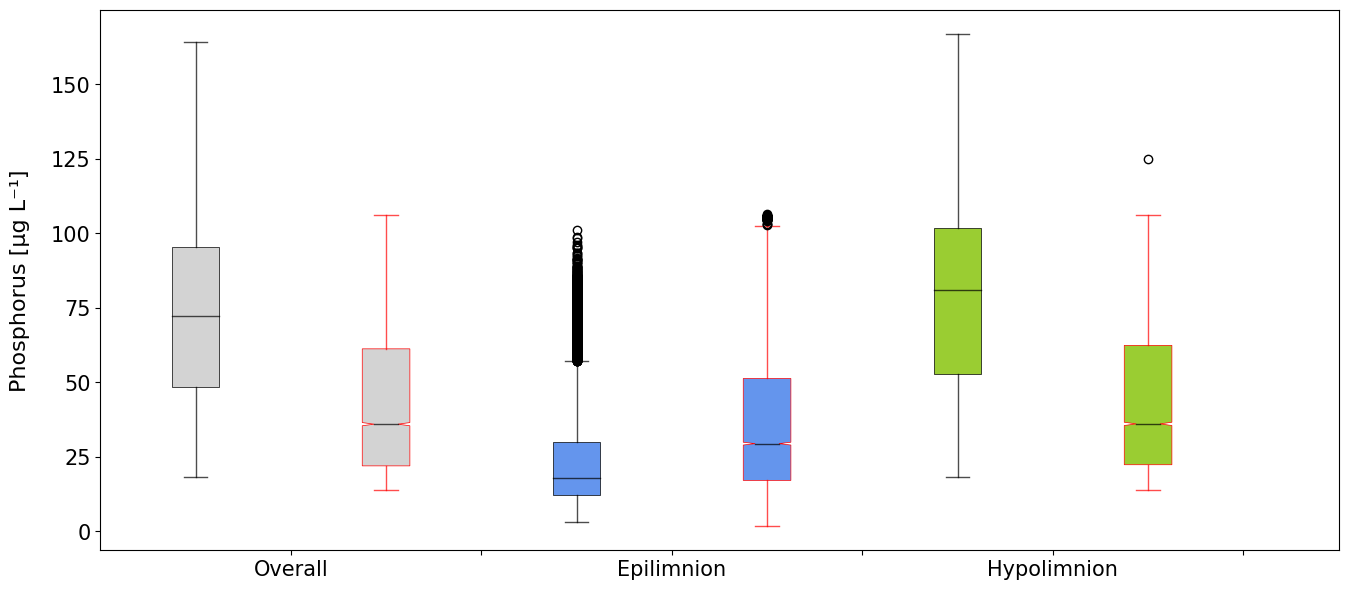

In [4]:
PLGM_OverallBoxplot(plgm)

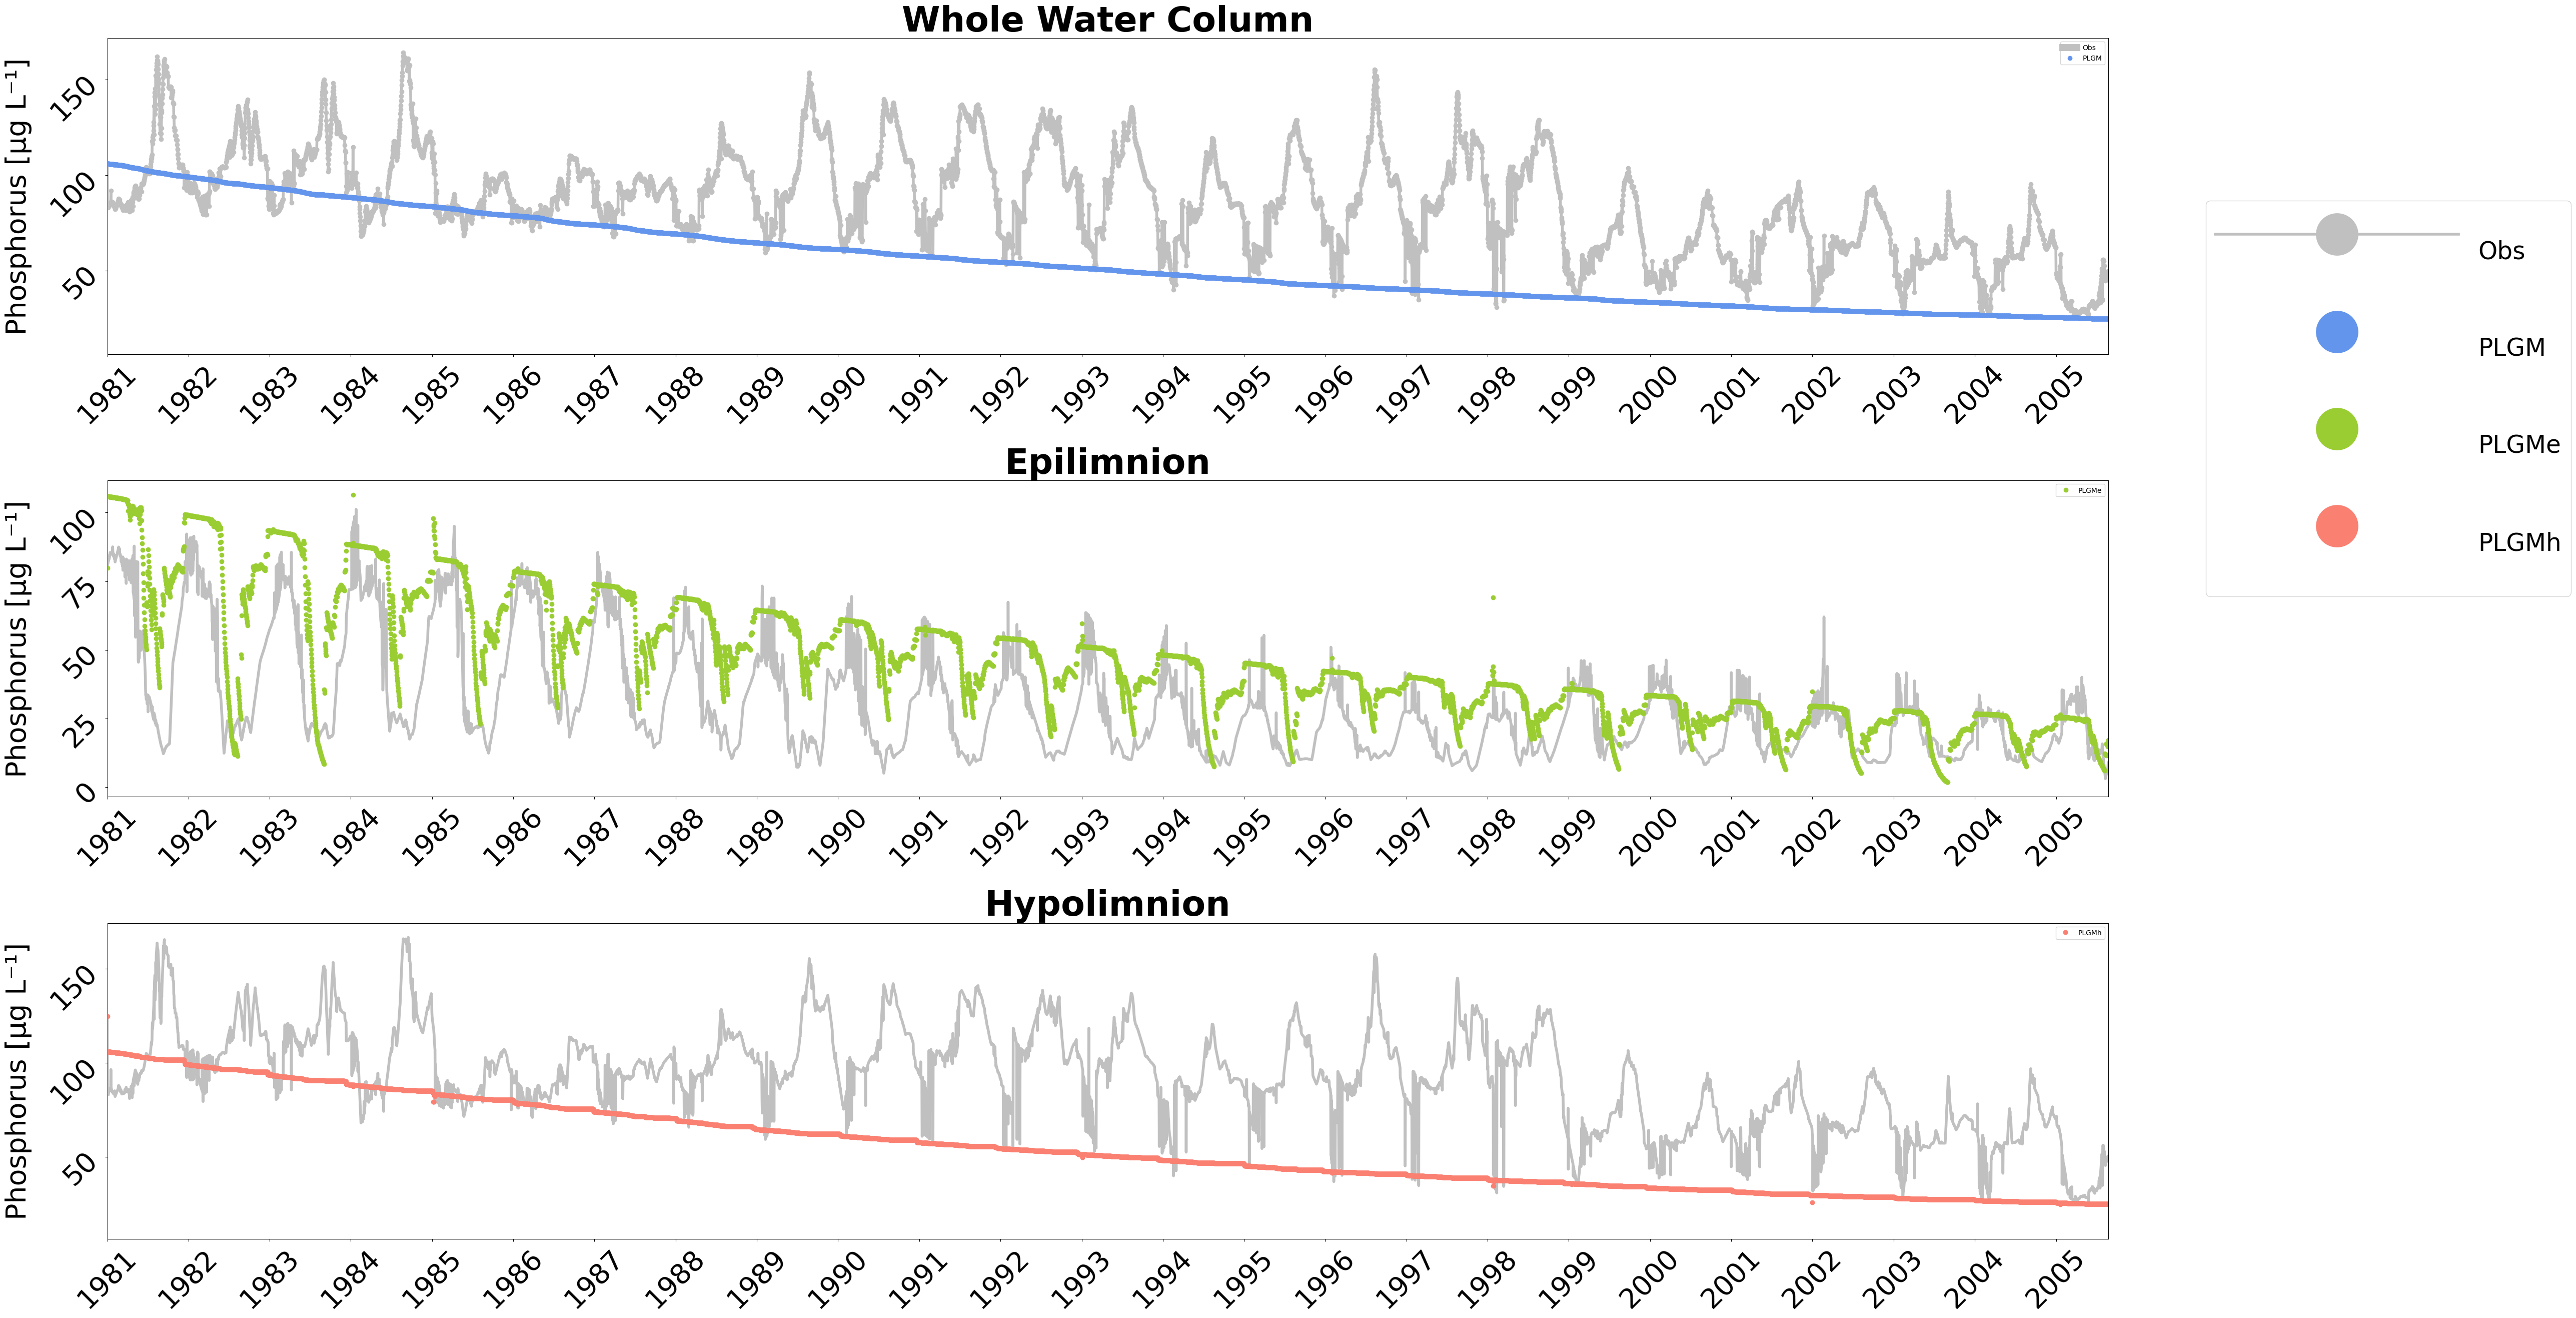

In [5]:
PLGM_OverallTimeSeries(plgm)

In [7]:
PLGM_OverallTable(plgm)

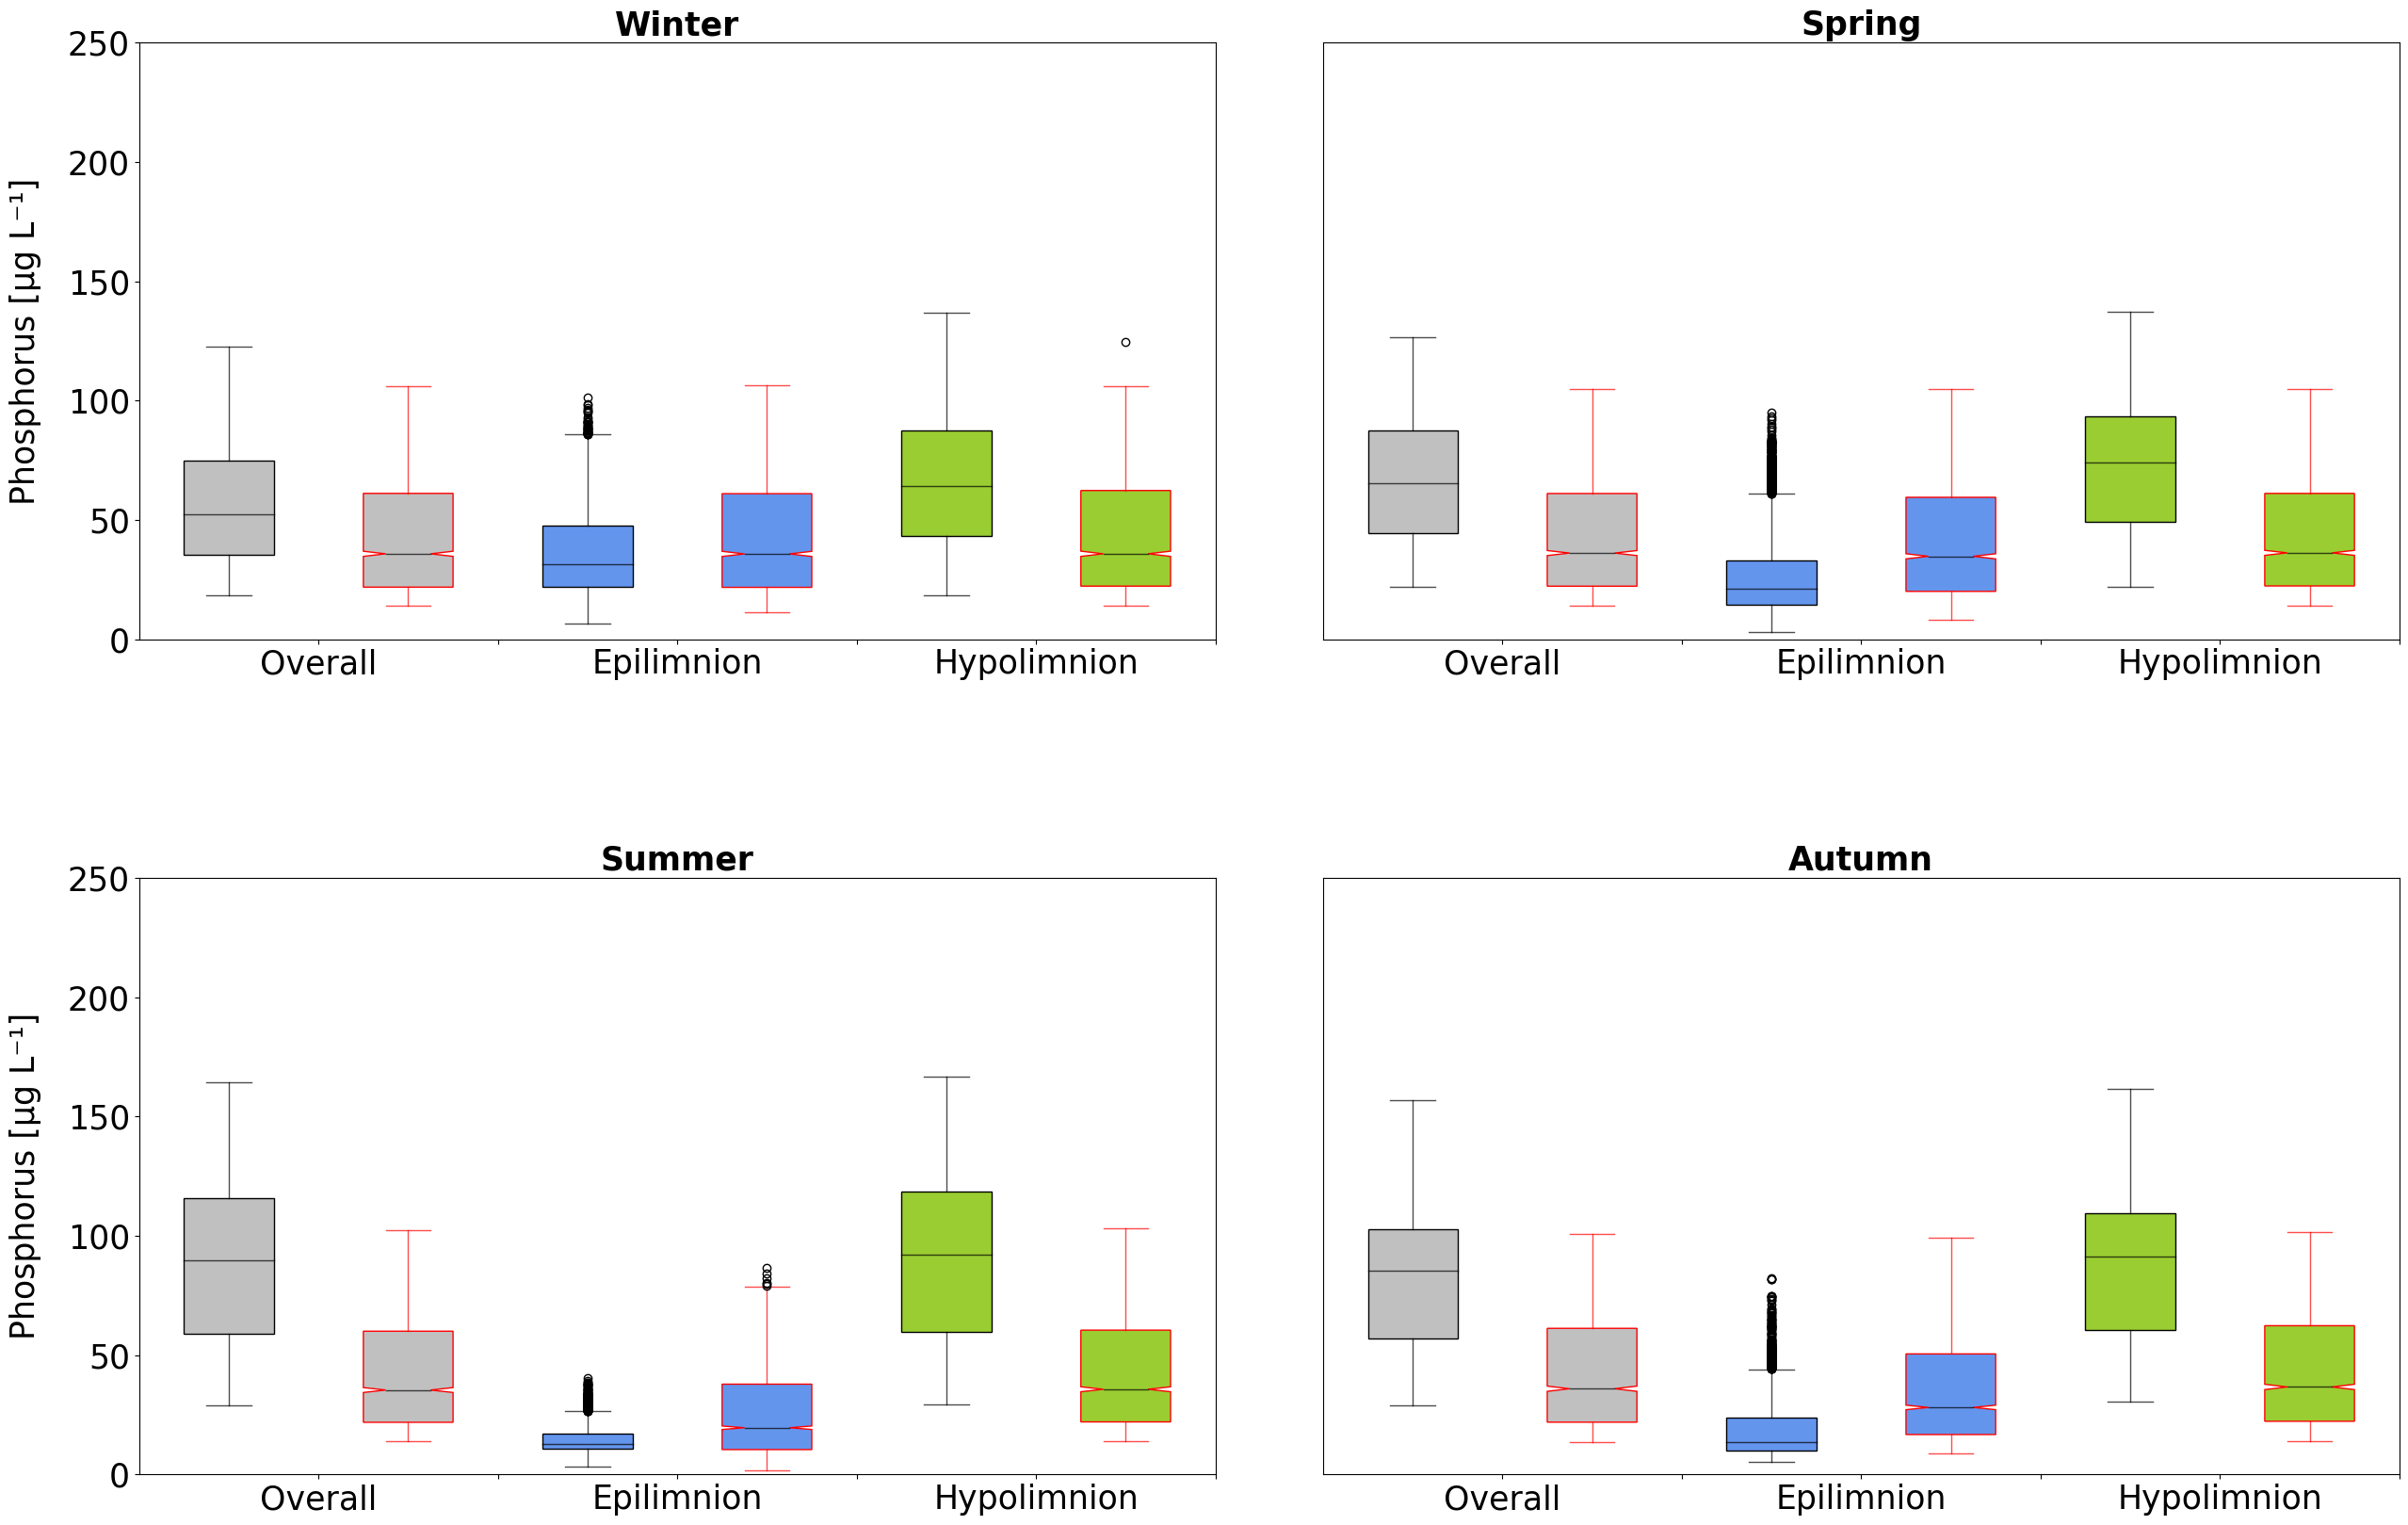

In [6]:
PLGM_SeasonalBoxplot(plgm)

In [4]:
PLGM_SeasonalTable(plgm)

##### Other data explorations

In [55]:
pt = lambda t,p:(p-t)/t 
for s in plgm.Season.unique():
    mask = plgm.Season ==s
    ve = plgm[mask]['EpiV[L]']
    vh = plgm[mask]['HypV[L]']
    vt = ve + vh
    PLGMe = plgm[mask]['EpiP[ug]']#*9.8421E-07#.describe()
    PLGMh = plgm[mask]['HypP[ug]']#*9.8421E-07#.describe()
    PLGM = PLGMe + PLGMh#.describe()
    OBSe = plgm[mask]['PEPItrue[ug]'].interpolate()#*9.8421E-07)#.describe()
    OBSh = plgm[mask]['HYPtrue[ug]'].interpolate()#*9.8421E-07)#.describe()
    OBS =  OBSe + OBSh
    PLGMs = plgm[mask]['Psed[ug]']/plgm[mask]['Sedv[L]']
    names = ['Overall','Epi','Hyp']
    print('________')
    print(s)
    data0 = [[OBS/vt,PLGM/vt],[OBSe/ve,PLGMe/ve],[OBSh/vh,PLGMh/vh]]
    for ix,i in enumerate(data0):
        if names[ix] == 'Overall':
            print(names[ix])
            print('')
            print(f'MEDIAN:    OBS:{np.median(i[0]):.0f}      PRED: {np.median(i[1]):.0f}')
            print(f'MIN:       OBS:{np.nanmin(i[0]):.0f}       PRED: {np.nanmin(i[1]):.0f}')
            print(f'MAX:       OBS:{np.nanmax(i[0]):.0f}     PRED: {np.nanmax(i[1]):.0f}')
            print('')
            v1 = np.median(own_norm(i[0],inf = True))  #obs
            v2 = np.median(own_norm(i[1],inf = True)) #pred
            mean = 0.5  # Mean of the distribution
            std = 0.1  # Standard deviation of the distribution
            size = len(own_norm(i[0],norm='None'))  # Number of samples to generate
            samples = np.random.normal(mean, std, size)

            e = pt(v1,v2)
            # axs[nx].hist(own_norm(i[0], inf = True),label = 'Obs')
            # axs[nx].hist(own_norm(i[1], inf = True),label =  n, alpha = 0.4)
            # axs[nx].hist(samples, label = 'ND', alpha = 0.4)
            # kl = wasserstein_distance(own_norm(i[0], inf = True),own_norm(i[1], inf = True))
            #         ND = wasserstein_distance(own_norm(i[1], inf = True),samples)

            # print(f'WS          :  {kl}')
            # print(f'OBS vs NORm :   {ND}')
            # print('')

________
spring
Overall

MEDIAN:    OBS:65      PRED: 35
MIN:       OBS:22       PRED: 14
MAX:       OBS:126     PRED: 104

________
summer
Overall

MEDIAN:    OBS:90      PRED: 35
MIN:       OBS:29       PRED: 14
MAX:       OBS:164     PRED: 102

________
autumn
Overall

MEDIAN:    OBS:85      PRED: 36
MIN:       OBS:29       PRED: 14
MAX:       OBS:157     PRED: 101

________
winter
Overall

MEDIAN:    OBS:51      PRED: 36
MIN:       OBS:18       PRED: 14
MAX:       OBS:123     PRED: 99



OBS
Prediction n°OBS vs Observed PLGM: 0.09
Observed n°PLGM vs Normal: 0.23
---------
PLGM
Prediction n°PLGM vs Observed OBSe: 0.12
Observed n°OBSe vs Normal: 0.29
---------
OBSe
Prediction n°OBSe vs Observed PLGMe: 0.11
Observed n°PLGMe vs Normal: 0.20
---------


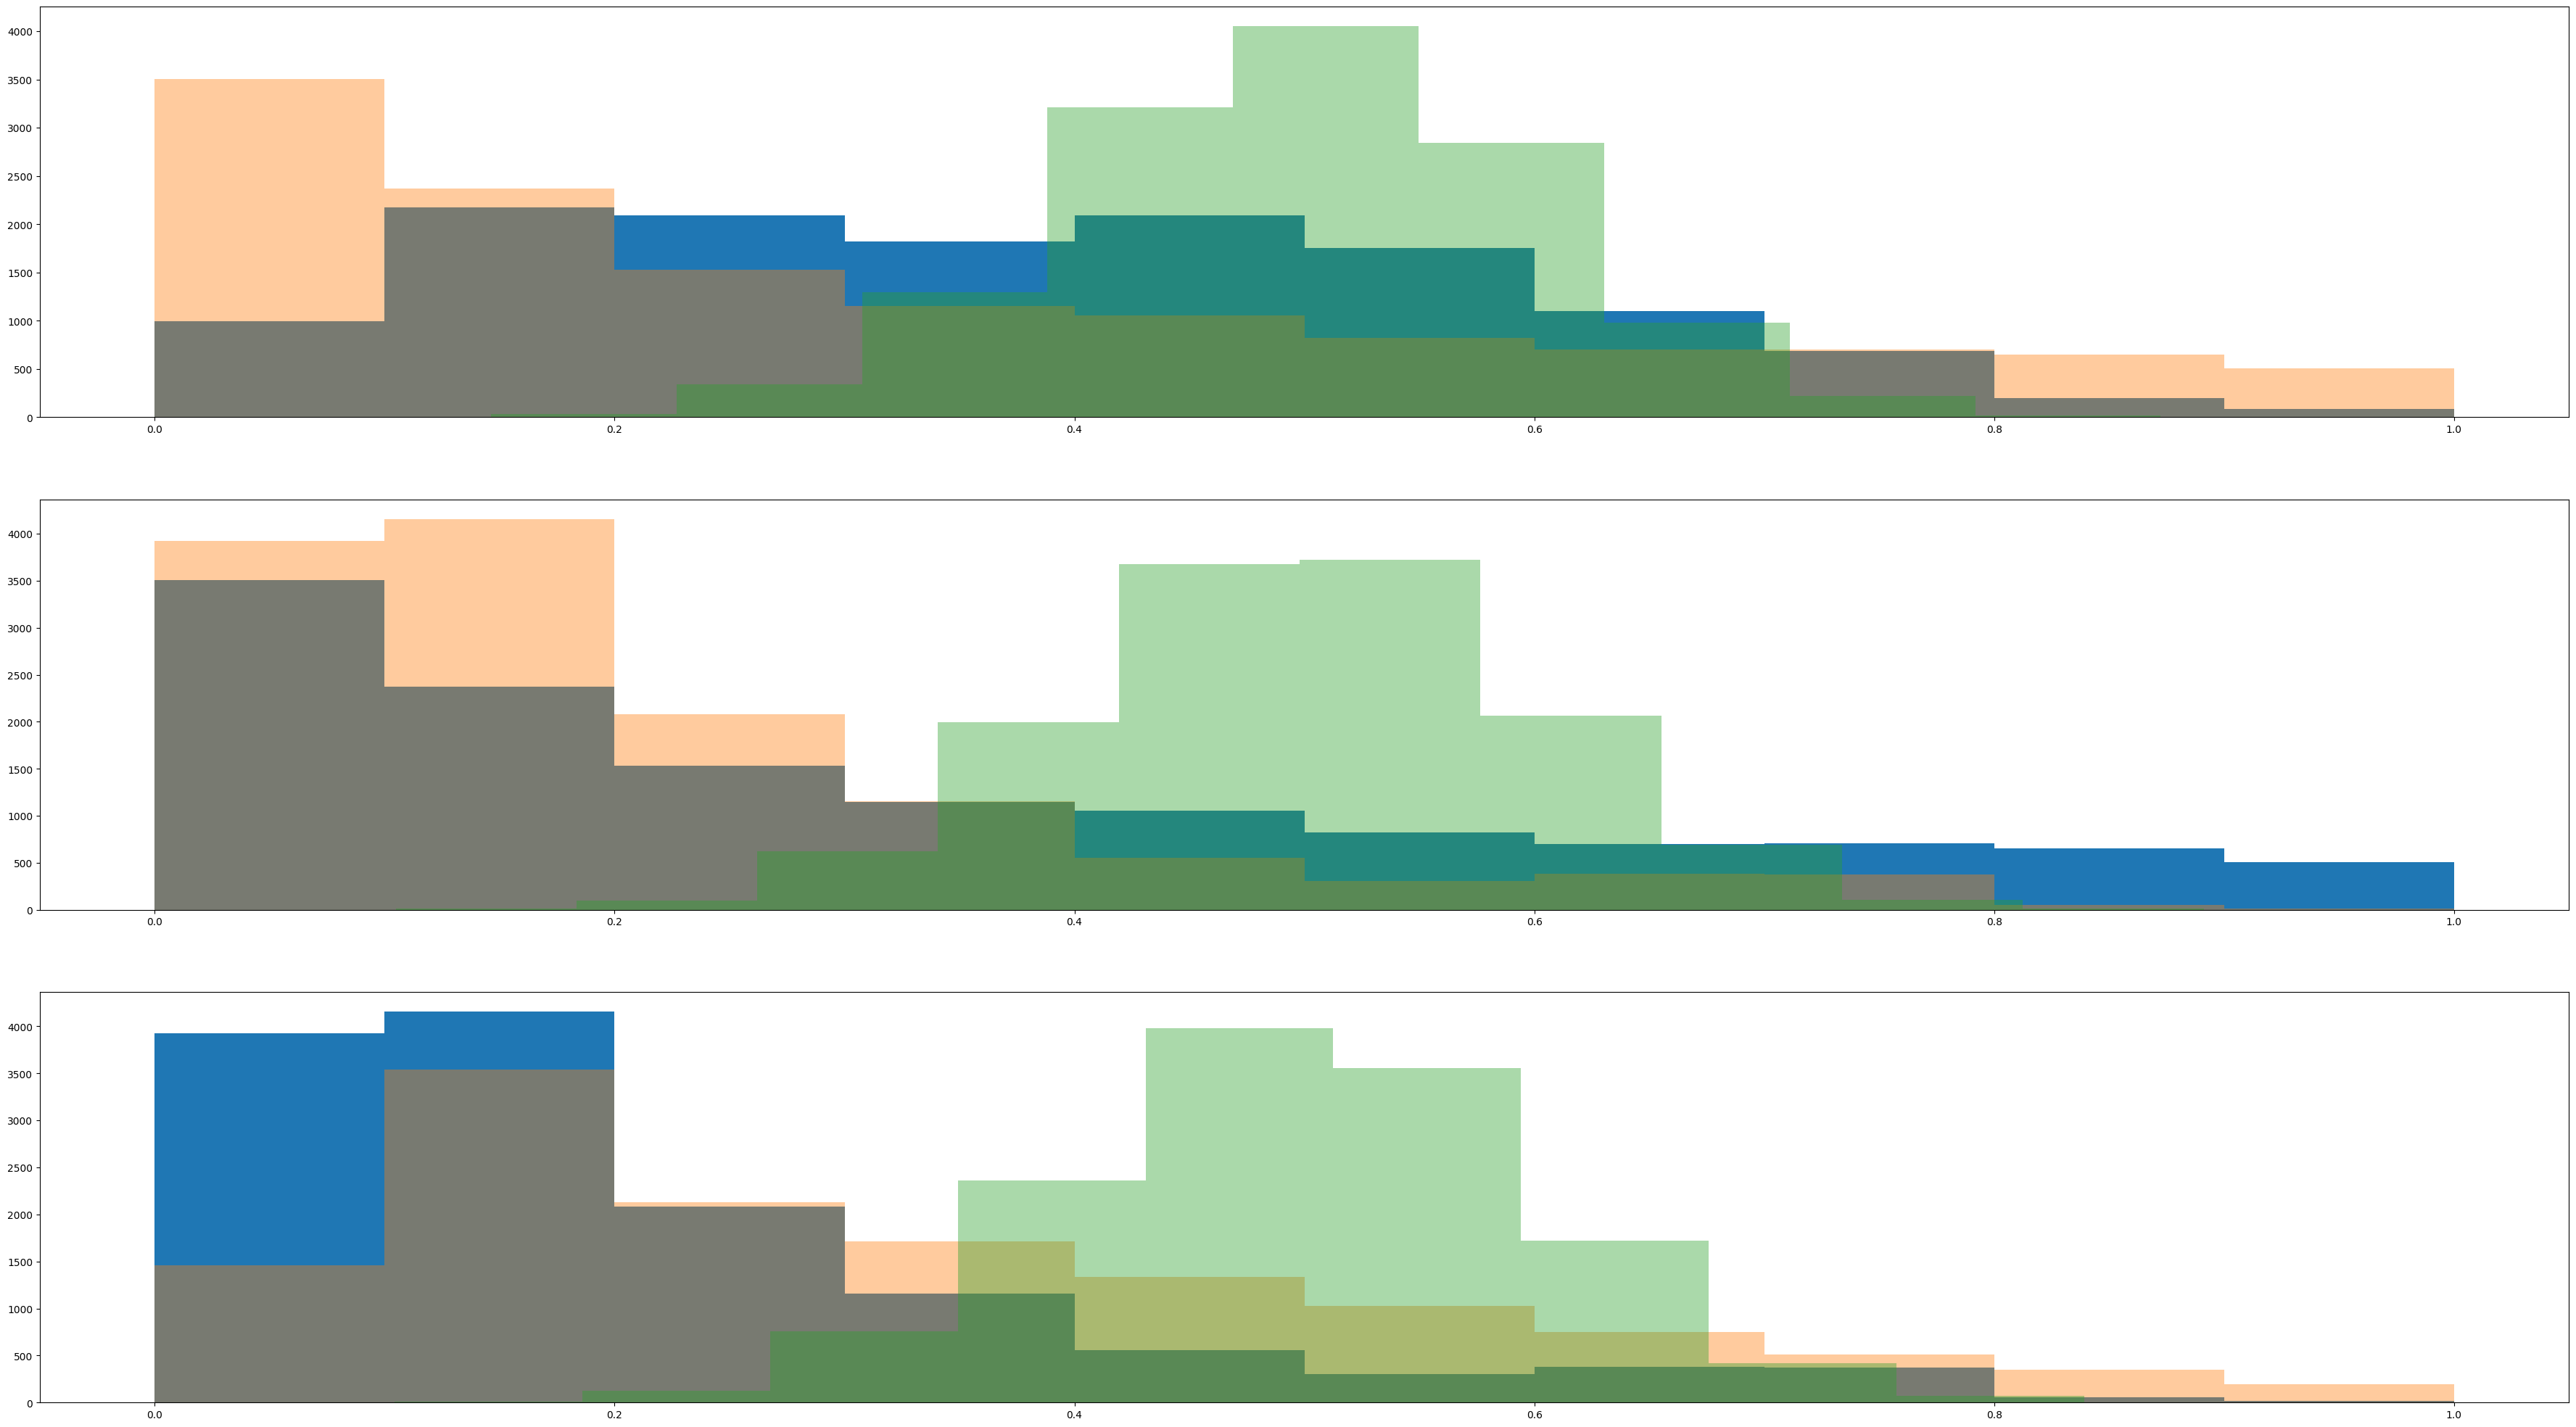

In [379]:
pt = lambda t,p:(p-t)/t 
ve = plgm['EpiV[L]']
vh = plgm['HypV[L]']
vt = ve + vh
PLGMe = plgm['EpiP[ug]']#*9.8421E-07#.describe()
PLGMh = plgm['HypP[ug]']#*9.8421E-07#.describe()
PLGM = PLGMe + PLGMh#.describe()
OBSe = plgm['PEPItrue[ug]'].interpolate()#*9.8421E-07)#.describe()
OBSh = plgm['HYPtrue[ug]'].interpolate()#*9.8421E-07)#.describe()
OBS =  OBSe + OBSh
PLGMs = plgm['Psed[ug]']/plgm['Sedv[L]']



d = pd.DataFrame()
for i, ix in zip([OBS/vt,PLGM/vt,OBSe/ve,PLGMe/ve,OBSh/vh,PLGMh/vh],['OBS','PLGM','OBSe','PLGMe','OBSh','PLGMh']):
    d[ix] = i
names = ['Overall','Epi','Hyp']
nn = ['OBS','PLGM','OBSe','PLGMe','OBSh','PLGMh']

r = {}
fig, axs = plt.subplots(3, 1, figsize=(45,25))



for nx,n in enumerate(names):
    v1 = np.median(own_norm(d.loc[:,nn[nx]],inf = True))  #obs
    v2 = np.median(own_norm(d.loc[:,nn[nx+1]],inf = True)) #pred
    
    mean = 0.5  # Mean of the distribution
    std = 0.1  # Standard deviation of the distribution
    size = len(own_norm(d.loc[:,nn[nx]],norm='None'))  # Number of samples to generate
    samples = np.random.normal(mean, std, size)
    
    e = pt(v1,v2)
    axs[nx].hist(own_norm(d.loc[:,nn[nx]], inf = True),label = 'Obs')
    axs[nx].hist(own_norm(d.loc[:,nn[nx+1]], inf = True),label =  n, alpha = 0.4)
    axs[nx].hist(samples, label = 'ND', alpha = 0.4)
    
    

    kl = wasserstein_distance(own_norm(d.loc[:,nn[nx]], inf = True),own_norm(d.loc[:,nn[nx+1]], inf = True))
    ND = wasserstein_distance(own_norm(d.loc[:,nn[nx+1]], inf = True),samples)
    print(nn[nx])
    print(f"Prediction n°{nn[nx]} vs Observed {nn[nx+1]}: {np.sum(abs(kl)):.2f}") 
    print(f"Observed n°{nn[nx+1]} vs Normal: {np.sum(abs(ND)):.2f}") 
    print('---------')
    # print('mean to mean')
    #print(e*100)
    # v1 = np.median(d.loc[:,nn[nx]])
    # v2 = np.median(d.loc[:,nn[nx+1]])
    # T = Ttest(own_norm(d.loc[:,nn[nx]], inf = True),own_norm(d.loc[:,nn[nx+1]], inf = True),ad = 0.05)
    # print(f'{n}:  {T},  {v1:.1f}   {v2:.1f}  ->  {pt(v1,v2)}')

###### PLGM RNN PGRNN

In [25]:
for s in plgm.Season.unique():    
    mask = plgm.Season == s
    ve = plgm[mask]['EpiV[L]']
    vh = plgm[mask]['HypV[L]']
    vt = ve + vh
    PLGMe = plgm[mask]['EpiP[ug]']#*9.8421E-07#.describe()
    PLGMh = plgm[mask]['HypP[ug]']#*9.8421E-07#.describe()
    PLGM = PLGMe + PLGMh#.describe()
    OBSe = plgm[mask]['PEPItrue[ug]'].interpolate()#*9.8421E-07)#.describe()
    OBSh = plgm[mask]['HYPtrue[ug]'].interpolate()#*9.8421E-07)#.describe()
    OBS =  OBSe + OBSh
    PLGMs = plgm[mask]['Psed[ug]']/plgm[mask]['Sedv[L]']
    names = ['Overall','Epi','Hyp']

    data0 = [[OBS/vt,PLGM/vt],[OBSe/ve,PLGMe/ve],[OBSh/vh,PLGMh/vh]]
    print('_____')
    print(s)
    for ix,i in enumerate(data0):
        if names[ix] == 'Epi':
            print(names[ix])
            # print('')
            # print(f'MEDIAN:    OBS:{np.median(i[0]):.0f}      PRED: {np.median(i[1]):.0f}')
            # print(f'MIN:       OBS:{np.nanmin(i[0]):.0f}       PRED: {np.nanmin(i[1]):.0f}')
            # print(f'MAX:       OBS:{np.nanmax(i[0]):.0f}     PRED: {np.nanmax(i[1]):.0f}')
            # print('')
            v1 = np.median(own_norm(i[0],inf = True))  #obs
            v2 = np.median(own_norm(i[1],inf = True)) #pred
            mean = 0.5  # Mean of the distribution
            std = 0.1  # Standard deviation of the distribution
            size = len(own_norm(i[0],norm='None'))  # Number of samples to generate
            samples = np.random.normal(mean, std, size)

            e = pt(v1,v2)
            # axs[nx].hist(own_norm(i[0], inf = True),label = 'Obs')
            # axs[nx].hist(own_norm(i[1], inf = True),label =  n, alpha = 0.4)
            # axs[nx].hist(samples, label = 'ND', alpha = 0.4)
            kl = wasserstein_distance(own_norm(i[0], inf = True),own_norm(i[1], inf = True))
            ND = wasserstein_distance(own_norm(i[1], inf = True),samples)

            print(f'WS          :  {kl}')
            print(f'OBS vs NORm :   {ND}')
            print('')

_____
spring
Epi
WS          :  0.095713428812547
OBS vs NORm :   0.20419081385746457

_____
summer
Epi
WS          :  0.0695349105755836
OBS vs NORm :   0.2270360229361555

_____
autumn
Epi
WS          :  0.10381115413667044
OBS vs NORm :   0.23186323438103526

_____
winter
Epi
WS          :  0.04939853715604288
OBS vs NORm :   0.2167707540450158



In [129]:
for ix, i in enumerate(plgm.Season.unique()):
    mask = plgm.Season == i

    plgm0 = plgm.interpolate()
    PLGMe = plgm0[mask]['EpiP[ug]']#*9.8421E-07#.describe()
    PLGMh = plgm0[mask]['HypP[ug]']#*9.8421E-07#.describe()
    PLGM = PLGMe + PLGMh#.describe()
    OBSe = plgm0[mask]['PEPItrue[ug]']#*9.8421E-07)#.describe()
    OBSh = plgm0[mask]['HYPtrue[ug]']#*9.8421E-07)#.describe()
    
    OBS =  OBSe + OBSh

    Etrue,Htrue,Epred,Hpred = OBSe,OBSh,PLGMe,PLGMh
    TTtrue = Etrue +Htrue
    TTpred = Epred +Hpred
    
    ev = plgm0[mask]['EpiV[L]']
    hv = plgm0[mask]['HypV[L]']
    tv = ev + hv
    
    vols = [[tv,tv],[ev,ev],[hv,hv]]
    d = [[TTtrue,TTpred],[Etrue,Epred],[Htrue,Hpred]]    
    names = ['HWC','EPI','HYP']
    print('________')
    print(i)
    print('________')
    nn = ['OBS','PLGM','OBSe','PLGMe','OBSh','PLGMh']
    for nx,n in enumerate(names):
        if n == 'EPI':#(n =='HWC' or n =='HYP'):
            dt = d[nx]
            print(n)
            mean = 0.5  # Mean of the distribution
            std = 0.1  # Standard deviation of the distribution
            size = len(own_norm(dt[0],norm='None'))  # Number of samples to generate
            samples = np.random.normal(mean, std, size)
            # print('obs')
            # print(((dt[0]/vols[nx][0]).describe().T)[['50%']].values[0])
            # print('pred')
            # print(((dt[1]/vols[nx][0]).describe().T)[['50%']].values[0])
            # print('dif')
            # print(np.median(dt[1]/vols[nx][0])/np.median(dt[0]/vols[nx][0]))

            kl = wasserstein_distance(own_norm(dt[0], inf = True),own_norm(dt[1], inf = True))
            ND = wasserstein_distance(own_norm(dt[0], inf = True),samples)
            print(f'{kl:.2f}')
            print(f'{ND:.2f}')

________
spring
________
EPI
0.03
0.40
________
summer
________
EPI
0.03
0.40
________
autumn
________
EPI
0.02
0.45
________
winter
________
EPI
0.06
0.19


### PLGM RNN PGRNN

In [2]:

RNN = pd.read_csv('RNNpred.csv')
RNN['Time']= pd.to_datetime(RNN.Time)
RNN= RNN.iloc[:,:].set_index('Time')[['RNNe']]

PGRNN = pd.read_csv('PGRNNdf1.csv') 
PGRNN['Time']= pd.to_datetime(PGRNN.Time)
PGRNN = PGRNN.iloc[:,:].set_index('Time')[['PGRNNe']]

plgm = pd.read_csv('plgm.csv').iloc[:,1:]
plgm.set_index(pd.to_datetime(plgm.Time),inplace = True)
plgm = plgm.assign(month  = [calendar.month_abbr[i] for i in list(plgm.index.month)])
plgm = pd.merge(plgm,RNN, left_index=True, right_index=True)
plgm = pd.merge(plgm,PGRNN, left_index=True, right_index=True)
plgm.rename(columns = {'EpiP[ug]':'MMpred','PEPItrue[ug]':'PEPItrue','RNNe':'RNNpred','PGRNNe':'HYB0pred'},inplace = True)
plgm = plgm.interpolate()
plgm['HYB0pred'] = plgm.iloc[:,-1].values*plgm['EpiV[L]'].values#plgm['HYB0pred']*plgm['EpiV[L]']

##### Visualization

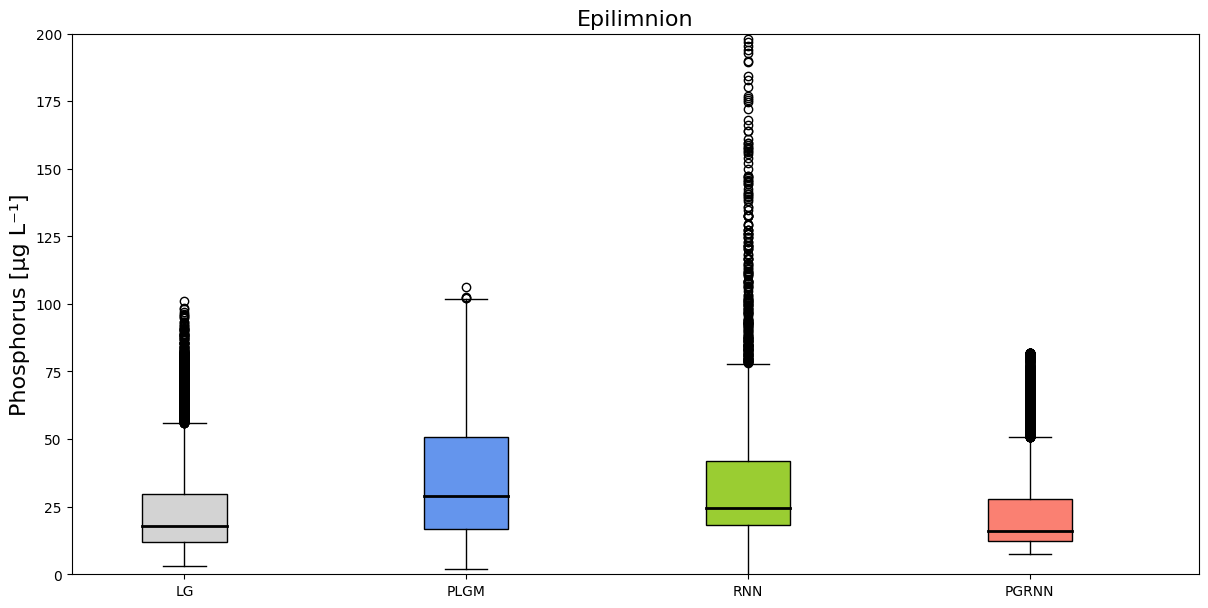

In [4]:
Bench_OverallBoxplot(plgm)

In [39]:
Bench_OverallTable(plgm)

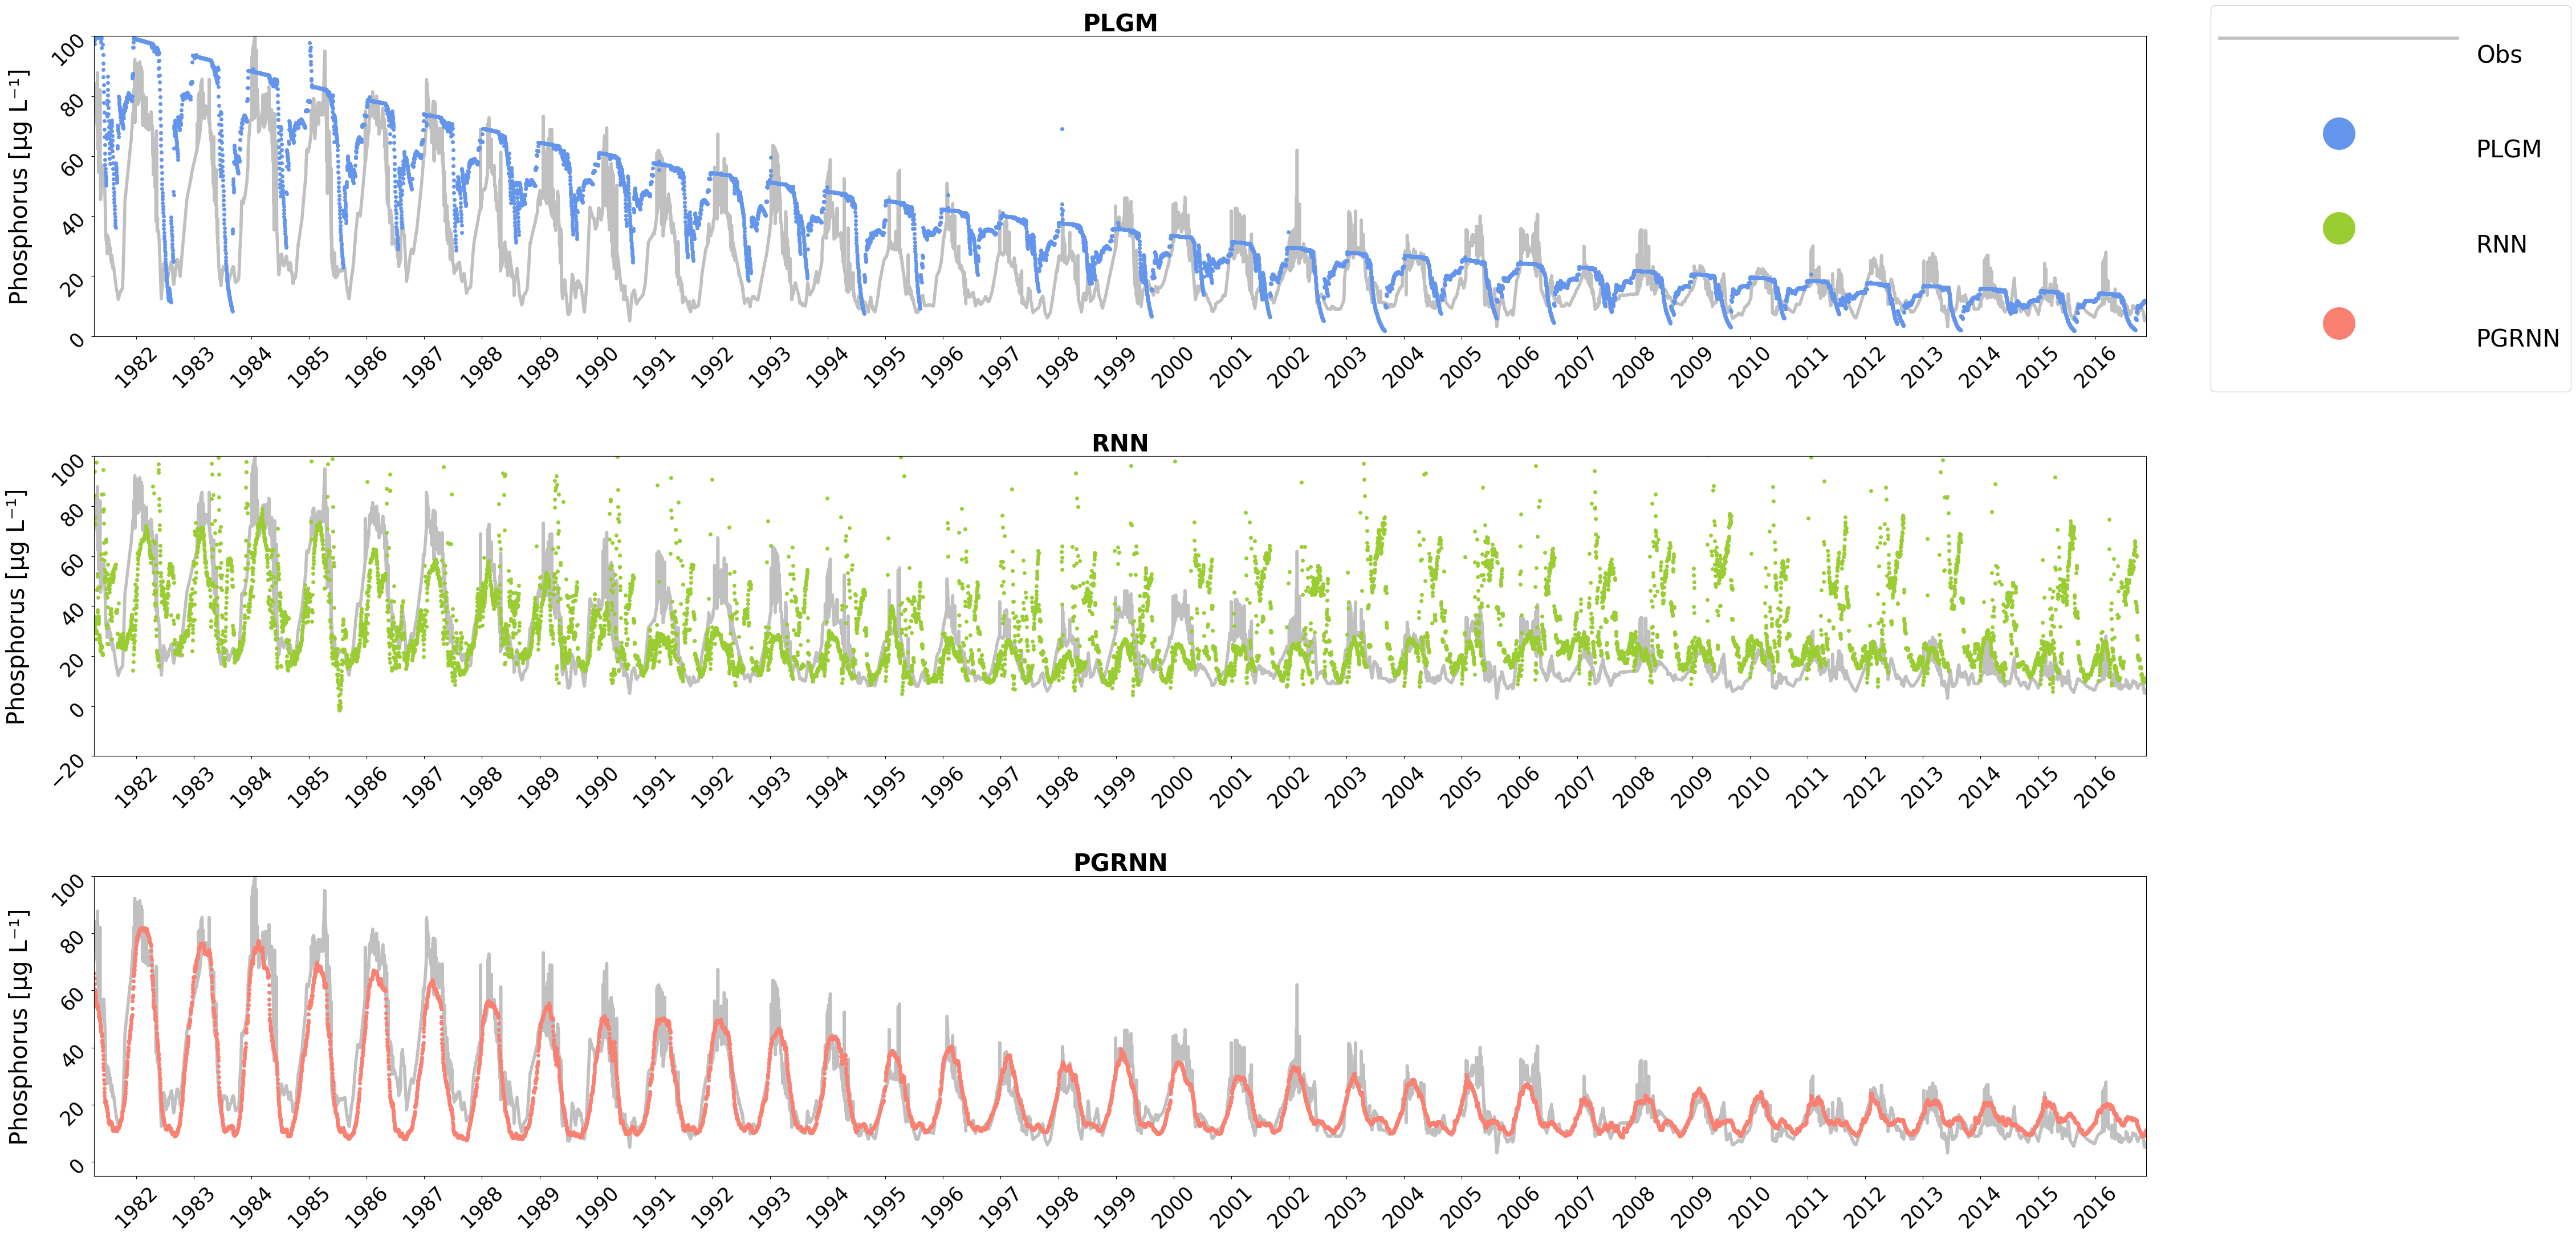

In [3]:
Bench_SeasonalTimeSeries(plgm)

winter
winter


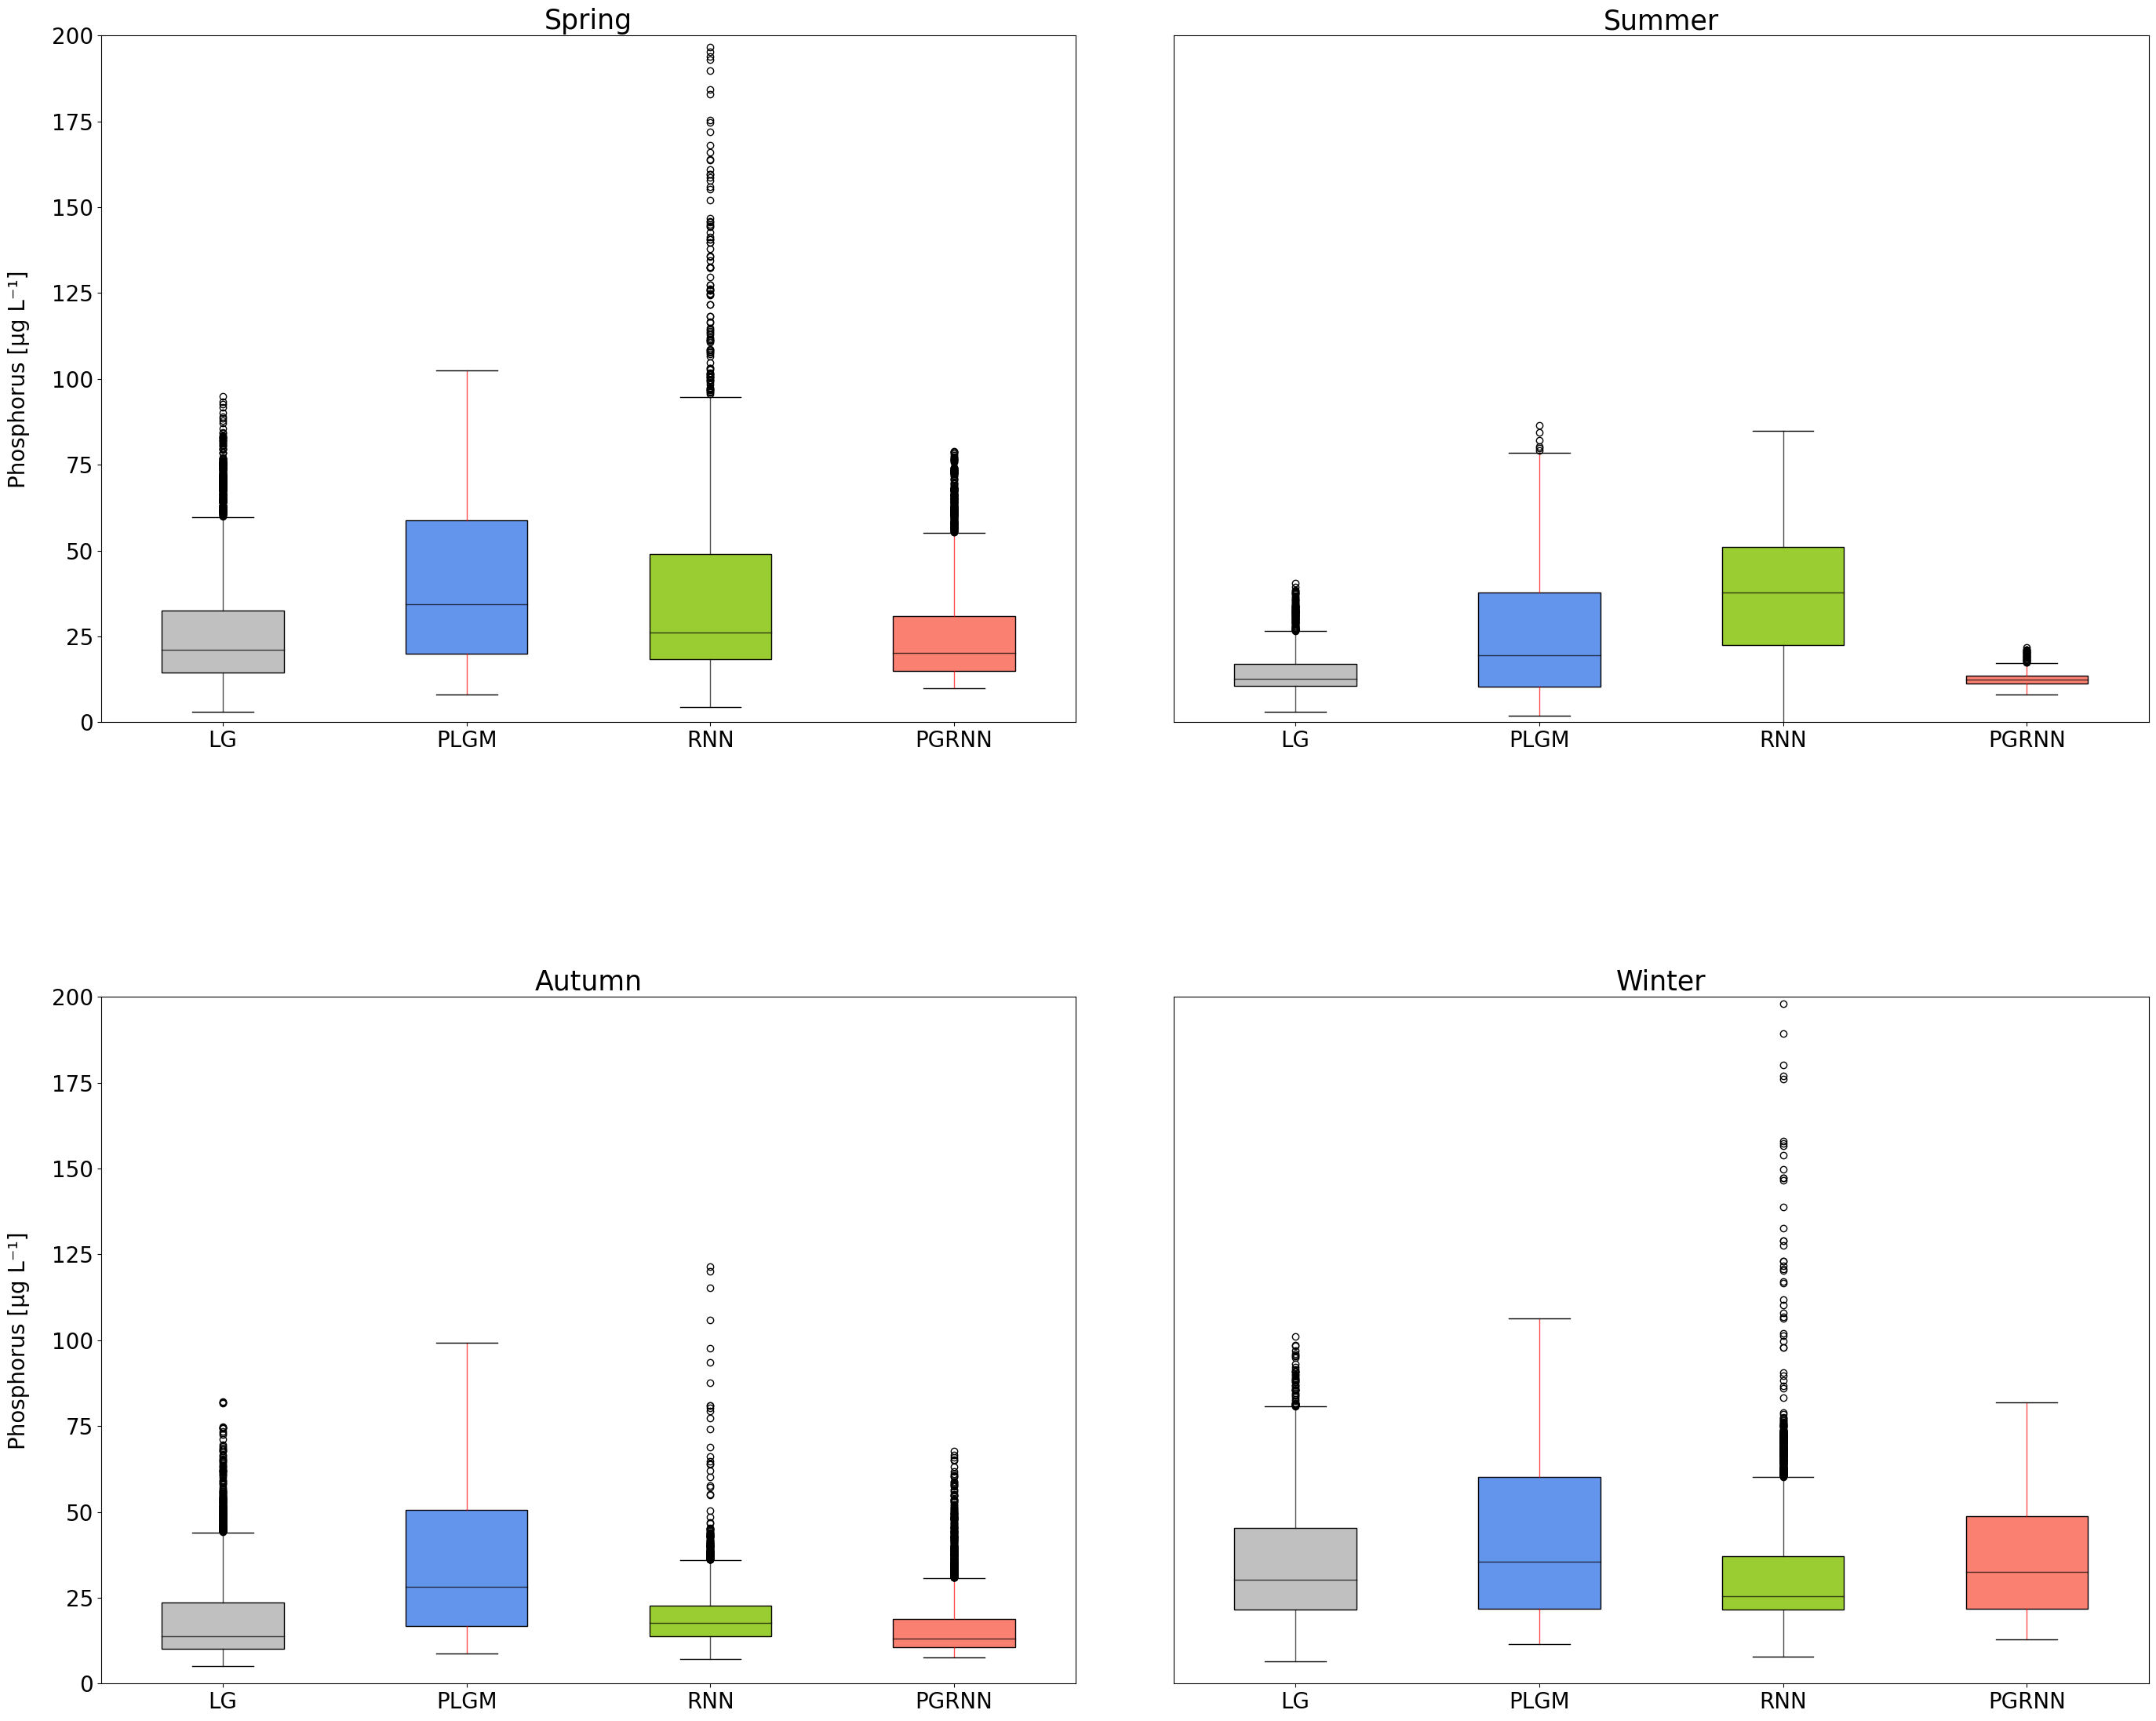

In [3]:
Bench_SeasonalBoxplot(plgm)

In [4]:
Bench_SeasonalTable(plgm)

##### General data exploration

In [27]:
data0 = [M,R,P]
t = plgm['PEPItrue']/vol
fe = lambda t,p: (p-t)/t
names = ['MMpred','RNNpred','HYB0pred']
print(f'LG: {np.median(t):.1f}')
for ix,i in enumerate(data0):
    print(names[ix])
    print(f' Median {np.median(i):.1f}')
    print(fe(np.median(t),np.median(i)))
    print('diff ?')
    print(Ttest(t,i,ad = .05))
    mean = 0.5  # Mean of the distribution
    std = 0.1  # Standard deviation of the distribution
    size = len(own_norm(t,norm='None'))  # Number of samples to generate
    samples = np.random.normal(mean, std, size)
    kl = wasserstein_distance(own_norm(t, inf = True),own_norm(i, inf = True))
    ND = wasserstein_distance(own_norm(t, inf = True),samples)
    print('wasserstein_distance')
    print(kl)
    print(ND)
    print('____\n')
    
    
    

LG: 17.8
MMpred
 Median 29.1
0.6324168316730413
diff ?
('(NOT NORM) Sig dif', 0.0)
wasserstein_distance
0.11202683032478483
0.2884359442608691
____

RNNpred
 Median 24.6
0.37805679470464226
diff ?
('(NOT NORM) Sig dif', 0.0)
wasserstein_distance
0.16922782006876255
0.28991411538206413
____

HYB0pred
 Median 15.9
-0.10658507561929677
diff ?
('(NOT NORM) Sig dif', 0.005721085273488595)
wasserstein_distance
0.03152747899211797
0.2879425002787601
____



In [ ]:
pt = lambda t,p:(p-t)/t 

for nx,n in enumerate(["MMpred","RNNpred",'HYB0pred']):
    v1 = own_norm(plgm["PEPItrue"]*9.8421E-07, inf = True)
    v2 = own_norm(plgm[n]*9.8421E-07, inf = True)
    
    
    kl = wasserstein_distance(v1,v2)
    print(n)
    print(f"Prediction n°{ix+1} vs Observed: {np.sum(abs(kl)):.2f}") 
    print('Mean')
    print(f'{np.mean(plgm[n]*9.8421E-07):.2e}')
    T = Ttest(v1,v2,ad =0.05)
    print('Dif?')
    print(T)
    print(f'{fe(np.mean(v1),np.mean(v2)):.2%}')
    print('----------\n')

mean = 0.5  # Mean of the distribution
std = 0.1  # Standard deviation of the distribution
size = len(own_norm(d[nx][0],norm='None'))  # Number of samples to generate
samples = np.random.normal(mean, std, size)
ND = wasserstein_distance(samples,v2) 

print('OBS')
print(f"Observed n°{ix+1} vs Normal: {np.sum(abs(ND)):.2f}")
print(f'{np.mean(plgm["PEPItrue"]*9.8421E-07):.2e}')
print('Mean')

### Sensitive analisis

In [5]:
p =r'C:\Users\gabri\OneDrive\Escritorio\UNIL\Thesis\MyWork\Geneva model\Process-model Geneva\Results.xlsx'
df = pd.read_excel('FI.xlsx').iloc[:,:-1]
df =df.drop(df[df['Variable'] == 'Export'].index)
df[df.Model =='PGRNN']

,Model,Variable
9,PGRNN,EpiPpred
10,PGRNN,EpiV
11,PGRNN,HypPpred
12,PGRNN,HypV
13,PGRNN,sol[W/m2]
14,PGRNN,u2*[m/s]
15,PGRNN,St
16,PGRNN,HypTemp
17,PGRNN,EpiTemp
18,PGRNN,PLoad


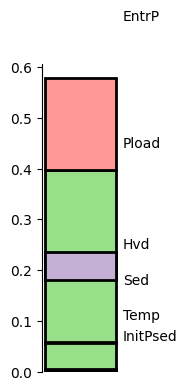

In [20]:
# Data
def SensPlot(var ='RNN', yyy = [0.6,0.4,0.27,0.17,0.11,0.07,0.02,0,0], perc =30):    
    '''
    y -> Variable name position
    '''
    Xvar = list(df[df.Model == var]['Variable'])
    Xval = list(df[df.Model == var]['Value'])
    groups = df.Variable.unique()

    colors = [
        '#1f77b4',  # Blue
        '#ff7f0e',  # Orange
        '#2ca02c',  # Green
        '#d62728',  # Red
        '#9467bd',  # Purple
        '#8c564b',  # Brown
        '#e377c2',  # Pink
        '#7f7f7f',  # Gray
        '#bcbd22',  # Olive
        '#17becf',  # Teal
        '#ffbb78',  # Coral
        '#98df8a',  # Mint
        '#ff9896',  # Salmon
        '#c5b0d5',  # Lavender
        '#c49c94',  # Tan
        '#f7b6d2',  # Rose
        '#c7c7c7',  # Silver
        '#dbdb8d',  # Chartreuse
        '#9edae5',  # Sky Blue
        '#aec7e8'   # Light Blue
    ]
    clrs = dict(zip(df.Variable.unique(), colors))


    fig, ax = plt.subplots(figsize =(1,4))

    bars = []
    for ix,i in enumerate(Xvar):
        tt=i
        if Xval[ix] < np.percentile(Xval, perc):
            tt =''
        else:
            ax.bar(0,Xval[ix],bottom=Xval[ix-1],color =clrs[i], #[clrs[i] for i in Xvar]
               edgecolor = "black", linewidth = 2, width =0.2)
            ax.text(0.12, yyy[ix], tt, horizontalalignment='left', verticalalignment='center', fontsize=10, color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Remove the x-axis spine (bottom spine)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False)
    ax.set_xticks([])
    plt.show()

COLORS= ['red','orange','yellow','blue','red','white','white','white']#'#98df8a','orange','yellow','pink','lightblue','white','white','white']
SensPlot('PLGM', yyy =[0.7,0.45,0.25,0.18,0.11,0.07,0.03,0,0,0],perc =33)
# plt.show()

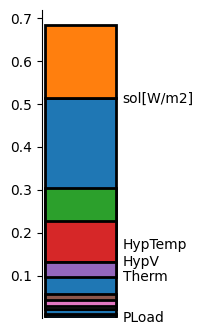

In [180]:
var ='RNN'
y = [0.6,0.4,0.27,0.17,0.11,0.07,0.02,0,0]
'''
y -> Variable name position
'''
Xvar = list(df[df.Model == var]['Variable'])
Xval = list(df[df.Model == var]['Value'])
groups = df.Variable.unique()
colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Olive
    '#17becf',  # Teal
    '#ffbb78',  # Coral
    '#98df8a',  # Mint
    '#ff9896',  # Salmon
    '#c5b0d5',  # Lavender
    '#c49c94',  # Tan
    '#f7b6d2',  # Rose
    '#c7c7c7',  # Silver
    '#dbdb8d',  # Chartreuse
    '#9edae5',  # Sky Blue
    '#aec7e8'   # Light Blue
]


clrs = dict(zip(df.Variable.unique(), colors))

fig, ax = plt.subplots(figsize =(1,4))
# Stacked bar chart
bars = []
for ix,i in enumerate(Xvar):
    tt=i
    bars = ax.bar(0,Xval[ix],bottom=Xval[ix-1], color = clrs[i], #[clrs[i] for i in Xvar]
           edgecolor = "black", linewidth = 2, width =0.2)
    bh = [b.get_height() for b in bars][0]
    bymin = [b.get_y() for b in bars][0]
    bymax = bh + bymin
    if Xval[ix] < np.percentile(Xval, 50):
        tt =''
    ax.text(0.12, bymin, tt, horizontalalignment='left', verticalalignment='center', fontsize=10, color='black')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Remove the x-axis spine (bottom spine)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.tick_params(axis='y', which='both', right=False)
ax.set_xticks([])
ax.get_xticks();

In [ ]:
def interv(scaled_list):
    intervals = [(0, scaled_list[0])]
    for i in range(1, len(scaled_list)):
        start = intervals[-1][1]
        end = start + scaled_list[i]
        intervals.append((start, end))
    return intervals